In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Custom Python Operators {#python-custom-ops-tutorial}
=======================

<div style="width: 45%; float: left; padding: 20px;"><h2> What you will learn</h2><ul><li>How to integrate custom operators written in Python with PyTorch</li><li>How to test custom operators using <code>torch.library.opcheck</code></li></ul></div><div style="width: 45%; float: right; padding: 20px;"><h2> Prerequisites</h2><ul><li>PyTorch 2.4 or later</li></ul></div>

PyTorch offers a large library of operators that work on Tensors (e.g.
`torch.add`, `torch.sum`, etc). However, you might wish to use a new
customized operator with PyTorch, perhaps written by a third-party
library. This tutorial shows how to wrap Python functions so that they
behave like PyTorch native operators. Reasons why you may wish to create
a custom operator in PyTorch include:

-   Treating an arbitrary Python function as an opaque callable with
    respect to `torch.compile` (that is, prevent `torch.compile` from
    tracing into the function).
-   Adding training support to an arbitrary Python function

Use `torch.library.custom_op`{.interpreted-text role="func"} to create
Python custom operators. Use the C++ `TORCH_LIBRARY` APIs to create C++
custom operators (these work in Python-less environments). See the
[Custom Operators Landing
Page](https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html)
for more details.

Please note that if your operation can be expressed as a composition of
existing PyTorch operators, then there is usually no need to use the
custom operator API \-- everything (for example `torch.compile`,
training support) should just work.


Example: Wrapping PIL\'s crop into a custom operator
\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\--Let\'s
say that we are using PIL\'s `crop` operation.


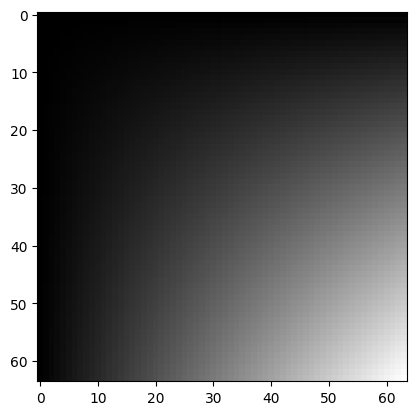

In [2]:
import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import PIL
import IPython
import matplotlib.pyplot as plt

def crop(pic, box):
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return pil_to_tensor(cropped_img).to(pic.device) / 255.

def display(img):
    plt.imshow(img.numpy().transpose((1, 2, 0)))

img = torch.ones(3, 64, 64)
img *= torch.linspace(0, 1, steps=64) * torch.linspace(0, 1, steps=64).unsqueeze(-1)
display(img)

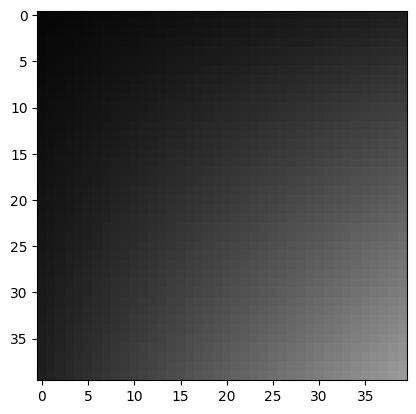

In [3]:
cropped_img = crop(img, (10, 10, 50, 50))
display(cropped_img)

`crop` is not handled effectively out-of-the-box by `torch.compile`:
`torch.compile` induces a [\"graph
break\"](https://pytorch.org/docs/stable/torch.compiler_faq.html#graph-breaks)
on functions it is unable to handle and graph breaks are bad for
performance. The following code demonstrates this by raising an error
(`torch.compile` with `fullgraph=True` raises an error if a graph break
occurs).


In [4]:
@torch.compile(fullgraph=True)
def f(img):
    return crop(img, (10, 10, 50, 50))

# The following raises an error. Uncomment the line to see it.
# cropped_img = f(img)

In order to black-box `crop` for use with `torch.compile`, we need to do
two things:

1.  wrap the function into a PyTorch custom operator.
2.  add a \"`FakeTensor` kernel\" (aka \"meta kernel\") to the operator.
    Given some `FakeTensors` inputs (dummy Tensors that don\'t have
    storage), this function should return dummy Tensors of your choice
    with the correct Tensor metadata (shape/strides/`dtype`/device).


In [5]:
from typing import Sequence

# Use torch.library.custom_op to define a new custom operator.
# If your operator mutates any input Tensors, their names must be specified
# in the ``mutates_args`` argument.
@torch.library.custom_op("mylib::crop", mutates_args=())
def crop(pic: torch.Tensor, box: Sequence[int]) -> torch.Tensor:
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return (pil_to_tensor(cropped_img) / 255.).to(pic.device, pic.dtype)

# Use register_fake to add a ``FakeTensor`` kernel for the operator
@crop.register_fake
def _(pic, box):
    channels = pic.shape[0]
    x0, y0, x1, y1 = box
    result = pic.new_empty(y1 - y0, x1 - x0, channels).permute(2, 0, 1)
    # The result should have the same metadata (shape/strides/``dtype``/device)
    # as running the ``crop`` function above.
    return result

After this, `crop` now works without graph breaks:


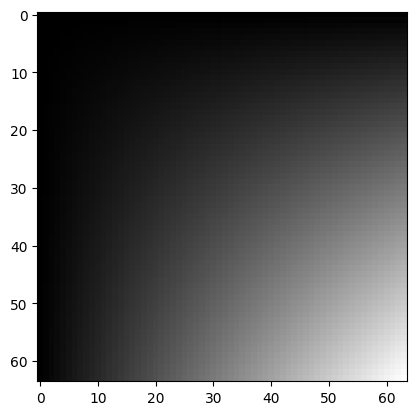

In [6]:
@torch.compile(fullgraph=True)
def f(img):
    return crop(img, (10, 10, 50, 50))

cropped_img = f(img)
display(img)

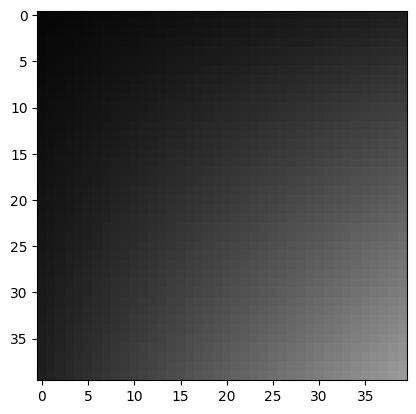

In [7]:
display(cropped_img)

Adding training support for crop
================================

Use `torch.library.register_autograd` to add training support for an
operator. Prefer this over directly using `torch.autograd.Function`;
some compositions of `autograd.Function` with PyTorch operator
registration APIs can lead to (and has led to) silent incorrectness when
composed with `torch.compile`.

If you don\'t need training support, there is no need to use
`torch.library.register_autograd`. If you end up training with a
`custom_op` that doesn\'t have an autograd registration, we\'ll raise an
error message.

The gradient formula for `crop` is essentially `PIL.paste` (we\'ll leave
the derivation as an exercise to the reader). Let\'s first wrap `paste`
into a custom operator:


In [8]:
@torch.library.custom_op("mylib::paste", mutates_args=())
def paste(im1: torch.Tensor, im2: torch.Tensor, coord: Sequence[int]) -> torch.Tensor:
    assert im1.device == im2.device
    assert im1.dtype == im2.dtype
    im1_pil = to_pil_image(im1.cpu())
    im2_pil = to_pil_image(im2.cpu())
    PIL.Image.Image.paste(im1_pil, im2_pil, coord)
    return (pil_to_tensor(im1_pil) / 255.).to(im1.device, im1.dtype)

@paste.register_fake
def _(im1, im2, coord):
    assert im1.device == im2.device
    assert im1.dtype == im2.dtype
    return torch.empty_like(im1)

And now let\'s use `register_autograd` to specify the gradient formula
for `crop`:


In [9]:
def backward(ctx, grad_output):
    grad_input = grad_output.new_zeros(ctx.pic_shape)
    grad_input = paste(grad_input, grad_output, ctx.coords)
    return grad_input, None

def setup_context(ctx, inputs, output):
    pic, box = inputs
    ctx.coords = box[:2]
    ctx.pic_shape = pic.shape

crop.register_autograd(backward, setup_context=setup_context)

Note that the backward must be a composition of PyTorch-understood
operators, which is why we wrapped paste into a custom operator instead
of directly using PIL\'s paste.


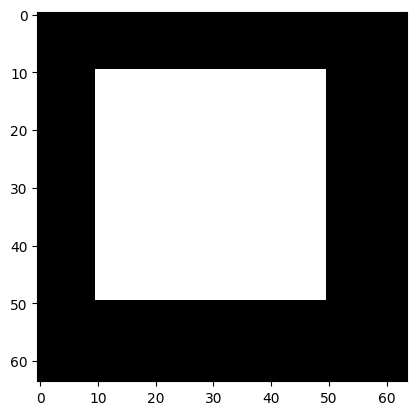

In [10]:
img = img.requires_grad_()
result = crop(img, (10, 10, 50, 50))
result.sum().backward()
display(img.grad)

This is the correct gradient, with 1s (white) in the cropped region and
0s (black) in the unused region.


Testing Python Custom operators
===============================

Use `torch.library.opcheck` to test that the custom operator was
registered correctly. This does not test that the gradients are
mathematically correct; please write separate tests for that (either
manual ones or `torch.autograd.gradcheck`).

To use `opcheck`, pass it a set of example inputs to test against. If
your operator supports training, then the examples should include
Tensors that require grad. If your operator supports multiple devices,
then the examples should include Tensors from each device.


In [11]:
examples = [
    [torch.randn(3, 64, 64), [0, 0, 10, 10]],
    [torch.randn(3, 91, 91, requires_grad=True), [10, 0, 20, 10]],
    [torch.randn(3, 60, 60, dtype=torch.double), [3, 4, 32, 20]],
    [torch.randn(3, 512, 512, requires_grad=True, dtype=torch.double), [3, 4, 32, 45]],
]

for example in examples:
    torch.library.opcheck(crop, example)

Mutable Python Custom operators
===============================

You can also wrap a Python function that mutates its inputs into a
custom operator. Functions that mutate inputs are common because that is
how many low-level kernels are written; for example, a kernel that
computes `sin` may take in the input and an output tensor and write
`input.sin()` to the output tensor.

We\'ll use `numpy.sin` to demonstrate an example of a mutable Python
custom operator.


In [12]:
import numpy as np

@torch.library.custom_op("mylib::numpy_sin", mutates_args={"output"}, device_types="cpu")
def numpy_sin(input: torch.Tensor, output: torch.Tensor) -> None:
    assert input.device == output.device
    assert input.device.type == "cpu"
    input_np = input.numpy()
    output_np = output.numpy()
    np.sin(input_np, out=output_np)

Because the operator doesn\'t return anything, there is no need to
register a `FakeTensor` kernel (meta kernel) to get it to work with
`torch.compile`.


In [13]:
@torch.compile(fullgraph=True)
def f(x):
    out = torch.empty(3)
    numpy_sin(x, out)
    return out

x = torch.randn(3)
y = f(x)
assert torch.allclose(y, x.sin())

And here\'s an `opcheck` run telling us that we did indeed register the
operator correctly. `opcheck` would error out if we forgot to add the
output to `mutates_args`, for example.


In [14]:
example_inputs = [
    [torch.randn(3), torch.empty(3)],
    [torch.randn(0, 3), torch.empty(0, 3)],
    [torch.randn(1, 2, 3, 4, dtype=torch.double), torch.empty(1, 2, 3, 4, dtype=torch.double)],
]

for example in example_inputs:
    torch.library.opcheck(numpy_sin, example)

Conclusion
==========

In this tutorial, we learned how to use `torch.library.custom_op` to
create a custom operator in Python that works with PyTorch subsystems
such as `torch.compile` and autograd.

This tutorial provides a basic introduction to custom operators. For
more detailed information, see:

-   [the torch.library
    documentation](https://pytorch.org/docs/stable/library.html)
-   [the Custom Operators
    Manual](https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html#the-custom-operators-manual)
